# C_b_1 : Recherche de modèles


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
import holidays
from rich import print
from datetime import date
from references import *
from src import *

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

In [2]:
print("Version XGBoost :", xgb.__version__)

Version XGBoost : 1.7.6

In [ ]:
# %load_ext jupyter_black

import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=55,
    target_version=black.TargetVersion.PY311,
)

## XGBoost

https://en.wikipedia.org/wiki/XGBoost

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed **gradient-boosted decision tree (GBDT)** machine learning library. It provides **parallel tree boosting** and is the leading machine learning library for regression, classification, and ranking problems.

> XGBoost gained significant favor in the last few years as a result of helping individuals and teams win virtually every Kaggle structured data competition. In these competitions, companies and researchers post data after which statisticians and data miners compete to produce the best models for predicting and describing the data. (https://www.nvidia.com/en-us/glossary/data-science/xgboost/)

### Exemple inspirant ce sujet

Vidéo partie 1 : https://youtu.be/vV12dGe_Fho?si=Zifv1O512VNiqJ8W  

---

# Première partie - Création d'un modèle initial

### Import des données et création des features

Nous utilisons les features sans valeurs catégoriques, car les catérories (Été, Printemps, etc..)  causent des problèmes au modèle plus loin. 

Nous enlevons aussi les valeurs NA. 

In [4]:
df = import_and_create_features_no_categorical(
    fin="20221231"
).dropna()

---

### Séparation des données d'entraînement et de test

Séparons les données en ensemble d'entraînement et ensemble de test, où la dernière année complète (2022) servire de test.

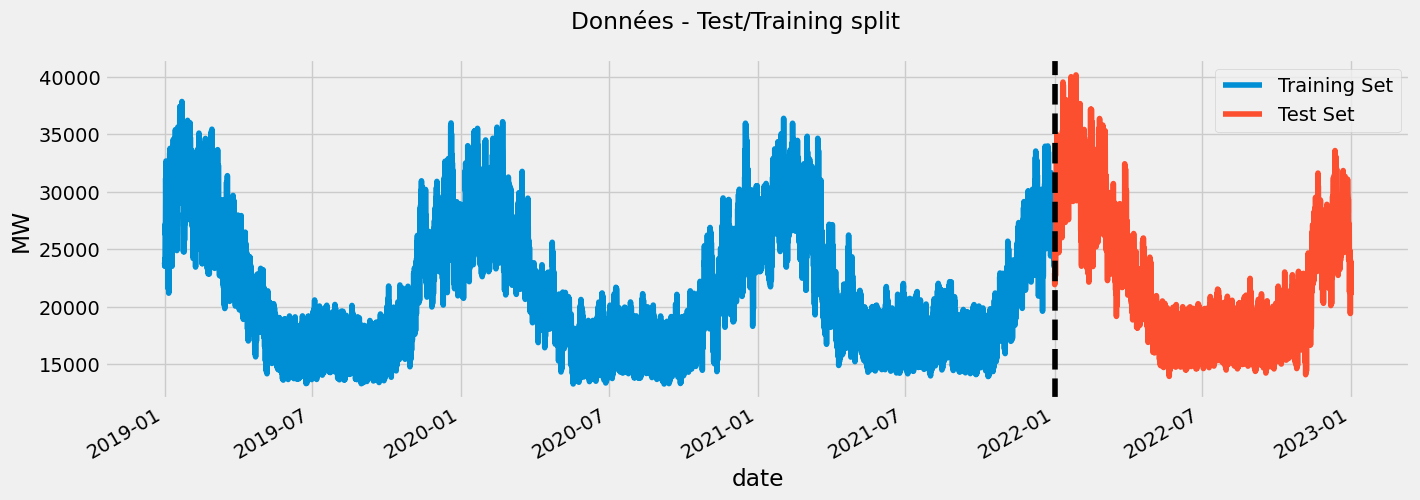

In [5]:
date_slit = "2022-01-01"

train = df.iloc[df.index < date_slit]
test = df.iloc[df.index >= date_slit]

fig, ax = plt.subplots(figsize=(15, 5))
train["MW"].plot(
    ax=ax, label="Training set", ylabel="MW"
)
test["MW"].plot(ax=ax, label="Test set")
ax.legend(["Training Set", "Test Set"])
ax.axvline(date_slit, color="black", ls="--")
fig.suptitle("Données - Test/Training split")
plt.show()

In [6]:
df.head()

,MW,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,month,dayofweek,season,isWeekend,isHoliday,day_sin,day_cos,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21,Temp_LAG_t-1h,DT_18-21_LAG_t-1h,DT_16-24_LAG_t-1h,DT_18_LAG_t-1h,DT_21_LAG_t-1h,Temp_LAG_t-2h,DT_18-21_LAG_t-2h,DT_16-24_LAG_t-2h,DT_18_LAG_t-2h,DT_21_LAG_t-2h,Temp_LAG_t-3h,DT_18-21_LAG_t-3h,DT_16-24_LAG_t-3h,DT_18_LAG_t-3h,DT_21_LAG_t-3h,Temp_LAG_t-4h,DT_18-21_LAG_t-4h,DT_16-24_LAG_t-4h,DT_18_LAG_t-4h,DT_21_LAG_t-4h,Temp_LAG_t-6h,DT_18-21_LAG_t-6h,DT_16-24_LAG_t-6h,DT_18_LAG_t-6h,DT_21_LAG_t-6h,Temp_LAG_t-24h,DT_18-21_LAG_t-24h,DT_16-24_LAG_t-24h,DT_18_LAG_t-24h,DT_21_LAG_t-24h,Temp_MOYMOBILE_t-1h,DT_18-21_MOYMOBILE_t-1h,DT_16-24_MOYMOBILE_t-1h,DT_18_MOYMOBILE_t-1h,DT_21_MOYMOBILE_t-1h,Temp_MOYMOBILE_t-2h,DT_18-21_MOYMOBILE_t-2h,DT_16-24_MOYMOBILE_t-2h,DT_18_MOYMOBILE_t-2h,DT_21_MOYMOBILE_t-2h,Temp_MOYMOBILE_t-3h,DT_18-21_MOYMOBILE_t-3h,DT_16-24_MOYMOBILE_t-3h,DT_18_MOYMOBILE_t-3h,DT_21_MOYMOBILE_t-3h,Temp_MOYMOBILE_t-4h,DT_18-21_MOYMOBILE_t-4h,DT_16-24_MOYMOBILE_t-4h,DT_18_MOYMOBILE_t-4h,DT_21_MOYMOBILE_t-4h,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,23762.55,0.0,1,1,2019,1,1,1,1,1,4,0,1,0.258819,0.965926,0.002738,0.999996,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-0.6,18.6,16.6,18.6,21.6,-1.5,19.5,17.5,19.5,22.5,-2.6,20.6,18.6,20.6,23.6,-9.9,27.9,25.9,27.9,30.9,0.0,18.0,16.0,18.0,21.0,0.00,18.00,16.00,18.00,21.00,-0.033333,18.033333,16.033333,18.033333,21.033333,-0.175,18.175,16.175,18.175,21.175,-0.750000,18.750000,16.750000,18.750000,21.750000,-4.795833,22.795833,20.795833,22.795833,25.795833
2019-01-01 02:00:00,23830.23,-0.2,2,1,2019,1,1,1,1,1,4,0,1,0.500000,0.866025,0.003455,0.999994,0.0,18.2,0.0,16.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-0.6,18.6,16.6,18.6,21.6,-2.3,20.3,18.3,20.3,23.3,-10.5,28.5,26.5,28.5,31.5,-0.2,18.2,16.2,18.2,21.2,-0.10,18.10,16.10,18.10,21.10,-0.066667,18.066667,16.066667,18.066667,21.066667,-0.075,18.075,16.075,18.075,21.075,-0.400000,18.400000,16.400000,18.400000,21.400000,-4.366667,22.366667,20.366667,22.366667,25.366667
2019-01-01 03:00:00,23608.07,-0.5,3,1,2019,1,1,1,1,1,4,0,1,0.707107,0.707107,0.004172,0.999991,0.0,18.5,0.0,16.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-1.5,19.5,17.5,19.5,22.5,-10.5,28.5,26.5,28.5,31.5,-0.5,18.5,16.5,18.5,21.5,-0.35,18.35,16.35,18.35,21.35,-0.233333,18.233333,16.233333,18.233333,21.233333,-0.175,18.175,16.175,18.175,21.175,-0.233333,18.233333,16.233333,18.233333,21.233333,-3.950000,21.950000,19.950000,21.950000,24.950000
2019-01-01 04:00:00,23562.48,-1.0,4,1,2019,1,1,1,1,1,4,0,1,0.866025,0.500000,0.004888,0.999988,0.0,19.0,0.0,17.0,19.0,17.0,19.0,22.0,-0.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.6,18.6,16.6,18.6,21.6,-10.9,28.9,26.9,28.9,31.9,-1.0,19.0,17.0,19.0,22.0,-0.75,18.75,16.75,18.75,21.75,-0.566667,18.566667,16.566667,18.566667,21.566667,-0.425,18.425,16.425,18.425,21.425,-0.300000,18.300000,16.300000,18.300000,21.300000,-3.537500,21.537500,19.537500,21.537500,24.537500
2019-01-01 05:00:00,23546.16,-1.1,5,1,2019,1,1,1,1,1,4,0,1,0.965926,0.258819,0.005605,0.999984,0.0,19.1,0.0,17.1,19.1,17.1,19.1,22.1,-1.0,19.0,17.0,19.0,22.0,-0.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-11.4,29.4,27.4,29.4,32.4,-1.1,19.1,17.1,19.1,22.1,-1.05,19.05,17.05,19.05,22.05,-0.866667,18.866667,16.866667,18.866667,21.866667,-0.700,18.700,16.700,18.700,21.700,-0.466667,18.466667,16.466667,18.466667,21.466667,-3.

### Création du modèle

In [7]:
df.columns

Index(['MW', 'Temp', 'hourofday', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'month', 'dayofweek', 'season', 'isWeekend', 'isHoliday', 'day_sin', 'day_cos', 'year_sin', 'year_cos', 'CDD_21', 'HDD_18', 'CDD_24', 'HDD_16', 'DT_18-21', 'DT_16-24', 'DT_18', 'DT_21', 'Temp_LAG_t-1h', 'DT_18-21_LAG_t-1h', 'DT_16-24_LAG_t-1h', 'DT_18_LAG_t-1h', 'DT_21_LAG_t-1h', 'Temp_LAG_t-2h', 'DT_18-21_LAG_t-2h', 'DT_16-24_LAG_t-2h', 'DT_18_LAG_t-2h', 'DT_21_LAG_t-2h', 'Temp_LAG_t-3h', 'DT_18-21_LAG_t-3h', 'DT_16-24_LAG_t-3h', 'DT_18_LAG_t-3h', 'DT_21_LAG_t-3h', 'Temp_LAG_t-4h', 'DT_18-21_LAG_t-4h', 'DT_16-24_LAG_t-4h', 'DT_18_LAG_t-4h', 'DT_21_LAG_t-4h', 'Temp_LAG_t-6h', 'DT_18-21_LAG_t-6h', 'DT_16-24_LAG_t-6h', 'DT_18_LAG_t-6h', 'DT_21_LAG_t-6h', 'Temp_LAG_t-24h', 'DT_18-21_LAG_t-24h', 'DT_16-24_LAG_t-24h', 'DT_18_LAG_t-24h', 'DT_21_LAG_t-24h', 'Temp_MOYMOBILE_t-1h', 'DT_18-21_MOYMOBILE_t-1h', 'DT_16-24_MOYMOBILE_t-1h', 'DT_18_MOYMOBILE_t-1h', 'DT_21_MOYMOBILE_t-1h',
       'Temp_MOYMOBI

Sélection de certaines features seulement pour débuter avec un modèle simple.

In [8]:
FEATURES_PRELIM = [
    "Temp",
    "hourofday",
    "dayofyear",
    "weekofyear",
    "season",
    "month",
    "DT_18",
]
TARGET = "MW"

X_train = train[FEATURES_PRELIM]
y_train = train[TARGET]

X_test = test[FEATURES_PRELIM]
y_test = test[TARGET]

In [9]:
n_estim = 2000  # nb trees

reg = xgb.XGBRegressor(
    n_estimators=n_estim,
    early_stopping_rounds=50,
    learning_rate=0.01,
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
)

[0]	validation_0-rmse:21674.01427	validation_1-rmse:22647.83498
[100]	validation_0-rmse:8034.79466	validation_1-rmse:8999.61141
[200]	validation_0-rmse:3125.22792	validation_1-rmse:4069.04895
[300]	validation_0-rmse:1495.89873	validation_1-rmse:2368.65531
[400]	validation_0-rmse:1057.38956	validation_1-rmse:1836.10044
[500]	validation_0-rmse:954.31266	validation_1-rmse:1660.22385
[600]	validation_0-rmse:923.92462	validation_1-rmse:1598.61130
[700]	validation_0-rmse:907.35117	validation_1-rmse:1579.94158
[800]	validation_0-rmse:891.96170	validation_1-rmse:1576.19202
[875]	validation_0-rmse:881.78055	validation_1-rmse:1577.17709


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [10]:
rmse_initial = reg.best_score

print(
    f"Le meilleur RMSE sur les données de tests est : {rmse_initial:0.2f}"
)

Le meilleur RMSE sur les données de tests est : 1576.00

Pour référence, nous avions un RMSE de **2399** sur la régression simple (Notebook B_c_3_Test_Statistique).

### Importance des Features

Importance relative des différents features. 

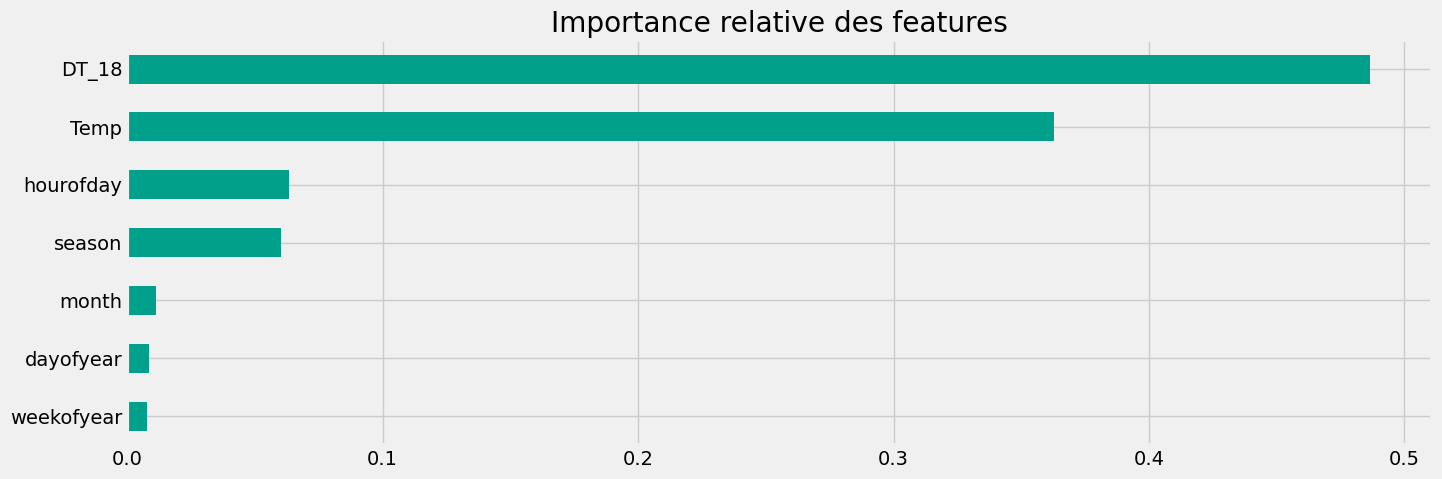

In [11]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values("Importance").plot(
    figsize=(15, 5),
    kind="barh",
    title="Importance relative des features",
    legend=False,
    color=colors_pal[1],
)
plt.show()

In [12]:
fi.sort_values("Importance", ascending=False)

,Importance
DT_18,0.486549
Temp,0.362852
hourofday,0.063172
season,0.060199
month,0.011106
dayofyear,0.008453
weekofyear,0.007667


In [13]:
ratio = (
    fi.loc[fi.index == "DT_18"]["Importance"][0]
    / fi.loc[fi.index == "Temp"]["Importance"][0]
)
print(
    f"Le ratio d'importance entre le DeltaT et la température en tant que telle est de {ratio:0.2f}, ce qui indique son importance relative, donc son degré de potentiel de prévision un par rapport à l'autre. "
)

Le ratio d'importance entre le DeltaT et la température en tant que telle est de 1.34, ce qui indique son 
importance relative, donc son degré de potentiel de prévision un par rapport à l'autre.

Aussi, les variables de température sont beaucoup plus importantes que les autres variables basées sur les temps et dates, ce que nous pouvions supposer avec l'évaluation statistique précédente. 

### Prédictions

In [14]:
test["prediction"] = reg.predict(X_test)

df_pred = df.merge(
    test[["prediction"]],
    how="left",
    left_index=True,
    right_index=True,
)

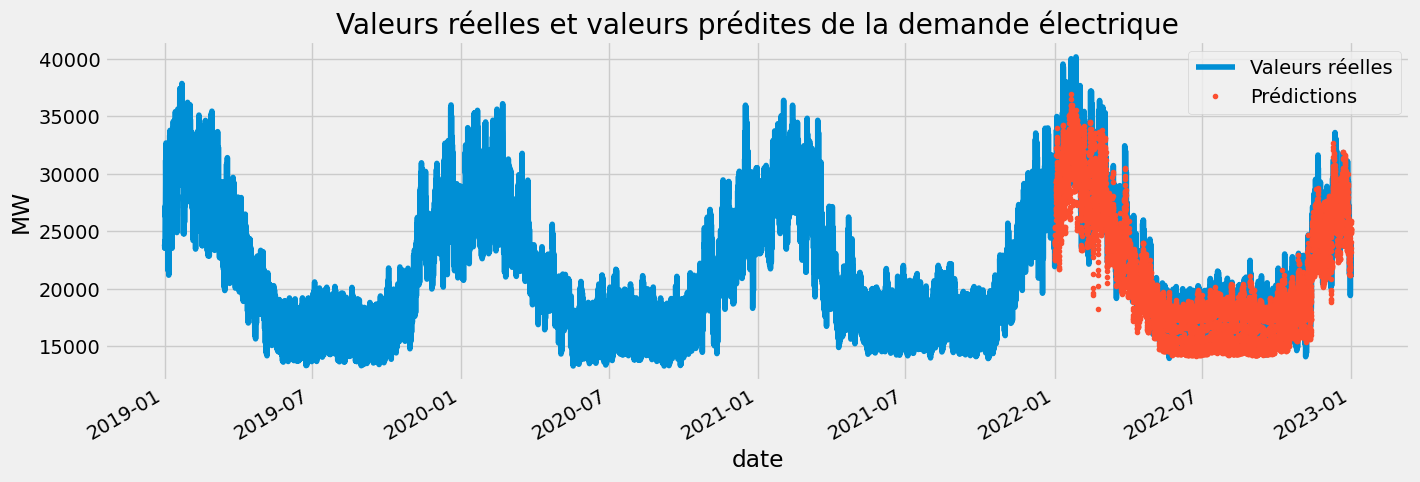

In [15]:
ax = df_pred.MW.plot(figsize=(15, 5), ylabel="MW")
df_pred.prediction.plot(ax=ax, style=".")
plt.legend(["Valeurs réelles", "Prédictions"])
ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique"
)

plt.show()

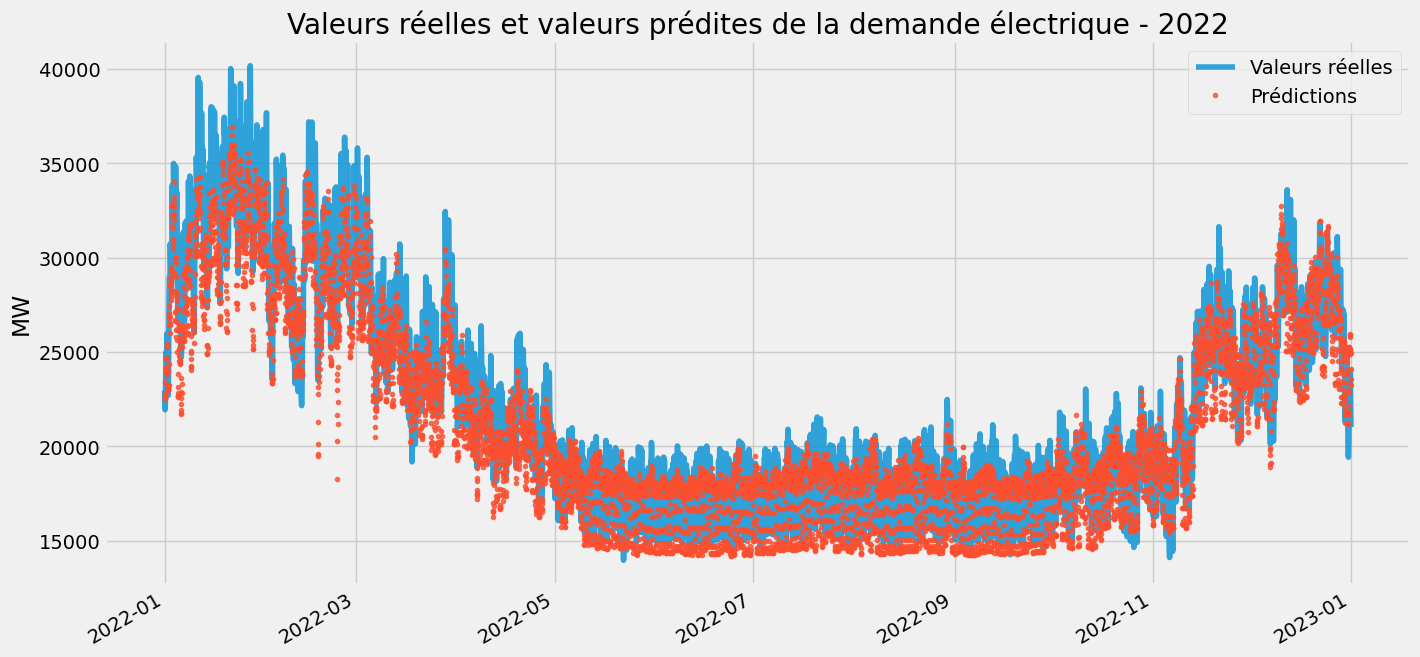

In [16]:
df_2022 = df_pred["20220101":"20221231"]

ax = df_2022.MW.plot(
    figsize=(15, 8), ylabel="MW", alpha=0.8
)
df_2022.prediction.plot(
    ax=ax, style=".", alpha=0.8, xlabel=""
)
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - 2022"
)

plt.show()

Nous pouvons voir que les journées extrêmes semblent être sous-estimées, par exemple en février 2022. 

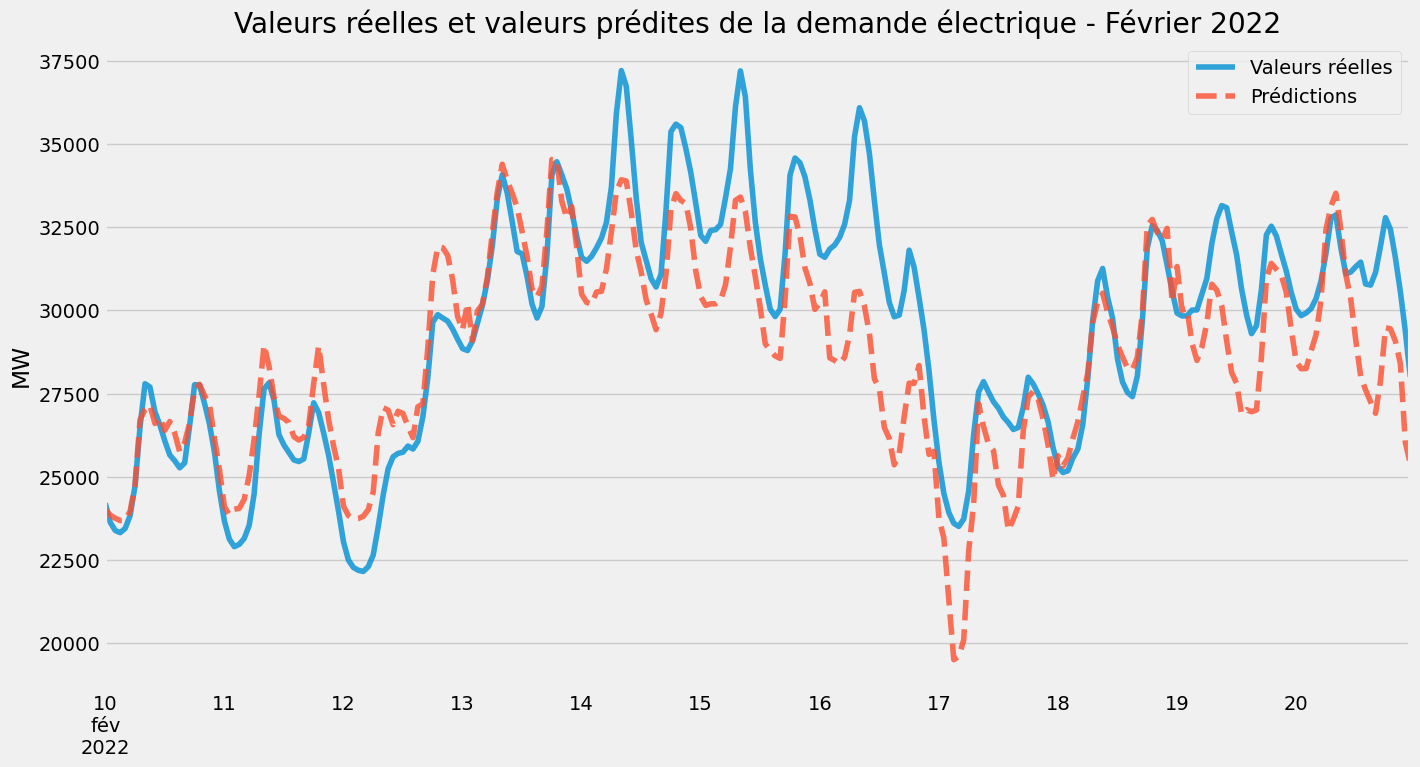

In [17]:
df_fev_2022 = df_pred["20220210":"20220220"]

ax = df_fev_2022.MW.plot(
    figsize=(15, 8), ylabel="MW", alpha=0.8
)
df_fev_2022.prediction.plot(
    ax=ax, style="--", alpha=0.8, xlabel=""
)
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - Février 2022"
)

plt.show()

Nous pouvons clairement voir les tendances des prévisions des valeurs réelles, copiant même la double pointe journalière le matin et en fin de journée. 

Lors des journées les plus extrêmes par contre, le modèle ne prédit pas de valeurs au-delà de 35000 MW, alors que la réalité va à près de 37500 MW.   Il n'y a possiblement pas assez de données dans les ensembles d'entraînement qui se rendent à ce niveau pour qu'il apprenne la limite. 

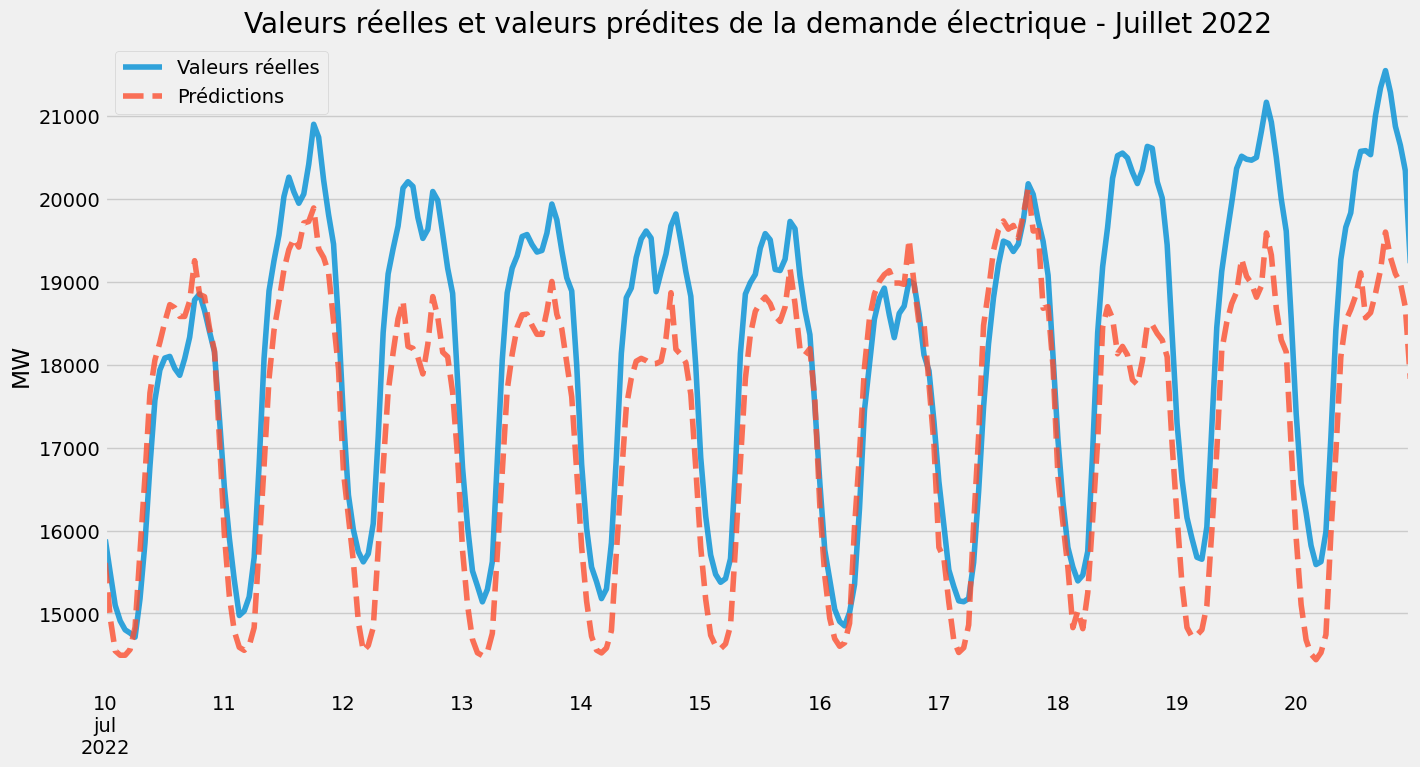

In [18]:
df_juin_2022 = df_pred["20220710":"20220720"]

ax = df_juin_2022.MW.plot(
    figsize=(15, 8), ylabel="MW", alpha=0.8
)
df_juin_2022.prediction.plot(
    ax=ax, style="--", alpha=0.8, xlabel=""
)
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - Juillet 2022"
)

plt.show()

En été, les prédictions semblent sous-estimer la demande en creux et en sommet de la demande, même si la forme est très bien prédite (la double pointe).

### Évaluation des métriques

In [19]:
# RMSE
score_RMSE = np.sqrt(
    mean_squared_error(test.MW, test.prediction)
)
print(f"RMSE : {score_RMSE:0.2f}")

RMSE : 1576.00

In [20]:
# Erreurs : erreur absolue moyenne sur la journée
test["error"] = np.abs(
    test[TARGET] - test["prediction"]
)

In [21]:
test["jour"] = test.index.date

In [22]:
pire_journee = (
    test.groupby("jour")["error"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
pire_journee

jour
2022-01-12    5911.056104
2022-01-27    4903.238649
2022-01-04    4811.152220
2022-01-05    4268.765098
2022-01-15    4116.055391
Name: error, dtype: float64

Les pires journées de prédiction sont durant le mois de janvier, quand les températures sont froides et que les pointes ne sont pas bien prédites par le modèle. 

Visualisons ces journées.

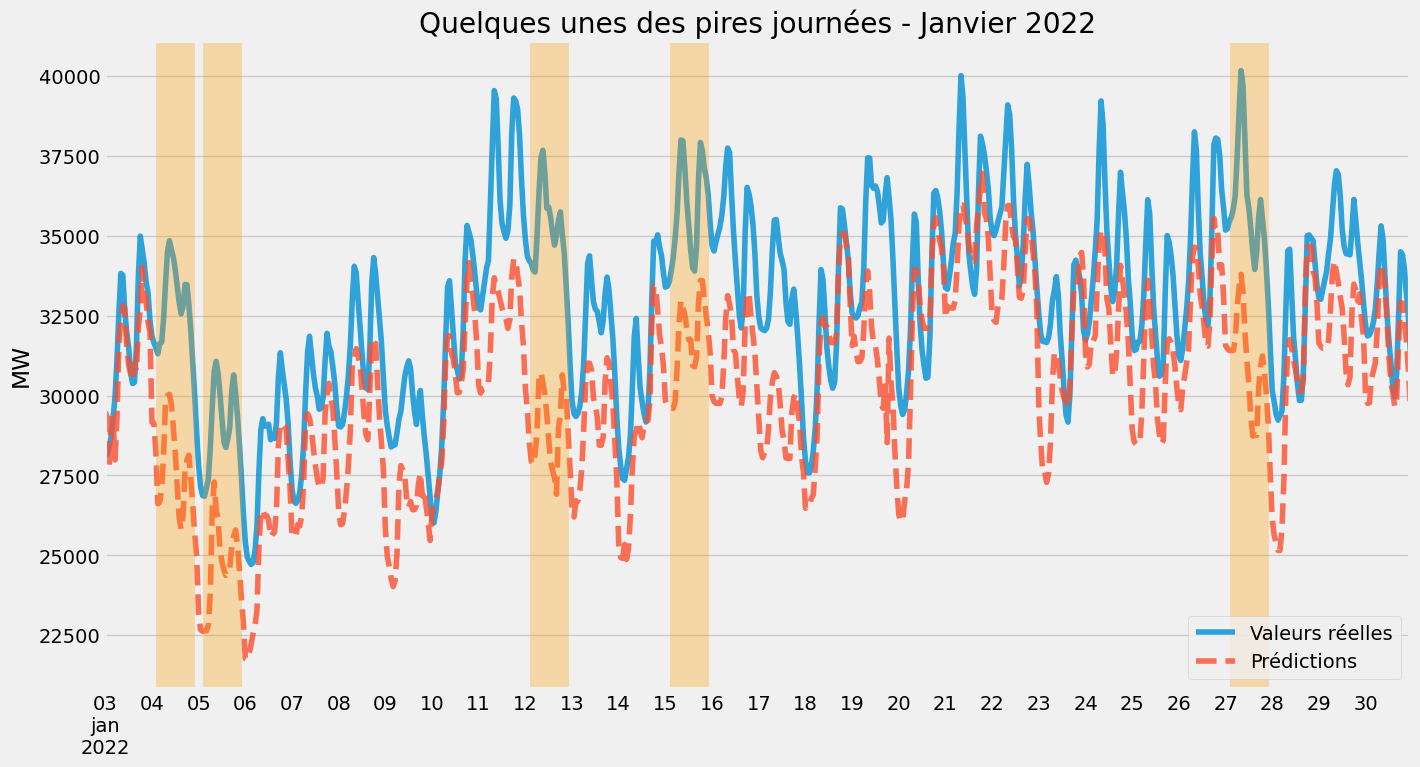

In [23]:
df_janv_2022 = df_pred["20220103":"20220130"]

ax = df_janv_2022.MW.plot(
    figsize=(15, 8), ylabel="MW", alpha=0.8
)
df_janv_2022.prediction.plot(
    ax=ax, style="--", alpha=0.8, xlabel=""
)
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Quelques unes des pires journées - Janvier 2022"
)

for jour in pire_journee.index.to_list():
    ax.axvline(
        datetime(
            jour.year, jour.month, jour.day, 12, 0
        ),
        color=colors_pal[11],
        linewidth=28,
        alpha=0.3,
    )

plt.show()

In [24]:
meilleure_journee = (
    test.groupby("jour")["error"]
    .mean()
    .sort_values(ascending=True)
    .head(5)
)
meilleure_journee

jour
2022-05-01    235.759971
2022-06-25    254.084676
2022-10-16    270.456375
2022-10-26    289.359010
2022-09-25    299.622476
Name: error, dtype: float64

À première vue, les meilleures journées de prédiction semblent être en mi-saison (printemps, début été et automne). 

## 2e passe : utilisation de l'ensemble des features

Tentons de trouver les meilleurs *features* qui sont déterminants pour le modèle.

In [25]:
FEATURES_TOUS = [
    "Temp",
    "hourofday",
    "quarter",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "month",
    "dayofweek",
    "season",
    "isWeekend",
    "isHoliday",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
    "CDD_21",
    "HDD_18",
    "CDD_24",
    "HDD_16",
    "DT_18-21",
    "DT_16-24",
    "DT_18",
    "DT_21",
    "Temp_LAG_t-1h",
    "DT_18-21_LAG_t-1h",
    "DT_16-24_LAG_t-1h",
    "DT_18_LAG_t-1h",
    "DT_21_LAG_t-1h",
    "Temp_LAG_t-2h",
    "DT_18-21_LAG_t-2h",
    "DT_16-24_LAG_t-2h",
    "DT_18_LAG_t-2h",
    "DT_21_LAG_t-2h",
    "Temp_LAG_t-3h",
    "DT_18-21_LAG_t-3h",
    "DT_16-24_LAG_t-3h",
    "DT_18_LAG_t-3h",
    "DT_21_LAG_t-3h",
    "Temp_LAG_t-4h",
    "DT_18-21_LAG_t-4h",
    "DT_16-24_LAG_t-4h",
    "DT_18_LAG_t-4h",
    "DT_21_LAG_t-4h",
    "Temp_LAG_t-6h",
    "DT_18-21_LAG_t-6h",
    "DT_16-24_LAG_t-6h",
    "DT_18_LAG_t-6h",
    "DT_21_LAG_t-6h",
    "Temp_LAG_t-24h",
    "DT_18-21_LAG_t-24h",
    "DT_16-24_LAG_t-24h",
    "DT_18_LAG_t-24h",
    "DT_21_LAG_t-24h",
    "Temp_MOYMOBILE_t-1h",
    "DT_18-21_MOYMOBILE_t-1h",
    "DT_16-24_MOYMOBILE_t-1h",
    "DT_18_MOYMOBILE_t-1h",
    "DT_21_MOYMOBILE_t-1h",
    "Temp_MOYMOBILE_t-2h",
    "DT_18-21_MOYMOBILE_t-2h",
    "DT_16-24_MOYMOBILE_t-2h",
    "DT_18_MOYMOBILE_t-2h",
    "DT_21_MOYMOBILE_t-2h",
    "Temp_MOYMOBILE_t-3h",
    "DT_18-21_MOYMOBILE_t-3h",
    "DT_16-24_MOYMOBILE_t-3h",
    "DT_18_MOYMOBILE_t-3h",
    "DT_21_MOYMOBILE_t-3h",
    "Temp_MOYMOBILE_t-4h",
    "DT_18-21_MOYMOBILE_t-4h",
    "DT_16-24_MOYMOBILE_t-4h",
    "DT_18_MOYMOBILE_t-4h",
    "DT_21_MOYMOBILE_t-4h",
    "Temp_MOYMOBILE_t-6h",
    "DT_18-21_MOYMOBILE_t-6h",
    "DT_16-24_MOYMOBILE_t-6h",
    "DT_18_MOYMOBILE_t-6h",
    "DT_21_MOYMOBILE_t-6h",
    "Temp_MOYMOBILE_t-24h",
    "DT_18-21_MOYMOBILE_t-24h",
    "DT_16-24_MOYMOBILE_t-24h",
    "DT_18_MOYMOBILE_t-24h",
    "DT_21_MOYMOBILE_t-24h",
]

X_train = train[FEATURES_TOUS]
y_train = train[TARGET]

X_test = test[FEATURES_TOUS]
y_test = test[TARGET]

In [26]:
n_estim = 2000  # nb trees

reg = xgb.XGBRegressor(
    n_estimators=n_estim,
    early_stopping_rounds=50,
    learning_rate=0.01,
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
)

[0]	validation_0-rmse:21673.83985	validation_1-rmse:22647.24468
[100]	validation_0-rmse:8010.26111	validation_1-rmse:8916.87065
[200]	validation_0-rmse:3042.98159	validation_1-rmse:3903.88951
[300]	validation_0-rmse:1294.07597	validation_1-rmse:2093.17041
[400]	validation_0-rmse:745.14084	validation_1-rmse:1464.08853
[500]	validation_0-rmse:592.63943	validation_1-rmse:1242.50774
[600]	validation_0-rmse:538.43881	validation_1-rmse:1167.62203
[700]	validation_0-rmse:511.27227	validation_1-rmse:1144.82015
[800]	validation_0-rmse:493.57035	validation_1-rmse:1136.57819
[900]	validation_0-rmse:477.79395	validation_1-rmse:1132.42706
[1000]	validation_0-rmse:465.04468	validation_1-rmse:1130.84258
[1100]	validation_0-rmse:453.13285	validation_1-rmse:1130.27342
[1161]	validation_0-rmse:446.54079	validation_1-rmse:1130.17473


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
rmse_tous_features = reg.best_score
print(
    f"Le meilleur RMSE sur les données d'entraînement est : {rmse_tous_features:0.2f} par rapport à {rmse_initial:0.2f} avec le calcul initial, soit {(rmse_initial-rmse_tous_features)/rmse_initial:0.0%} mieux."
)

Le meilleur RMSE sur les données d'entraînement est : 1129.95 par rapport à 1576.00 avec le calcul initial, soit 
28% mieux.

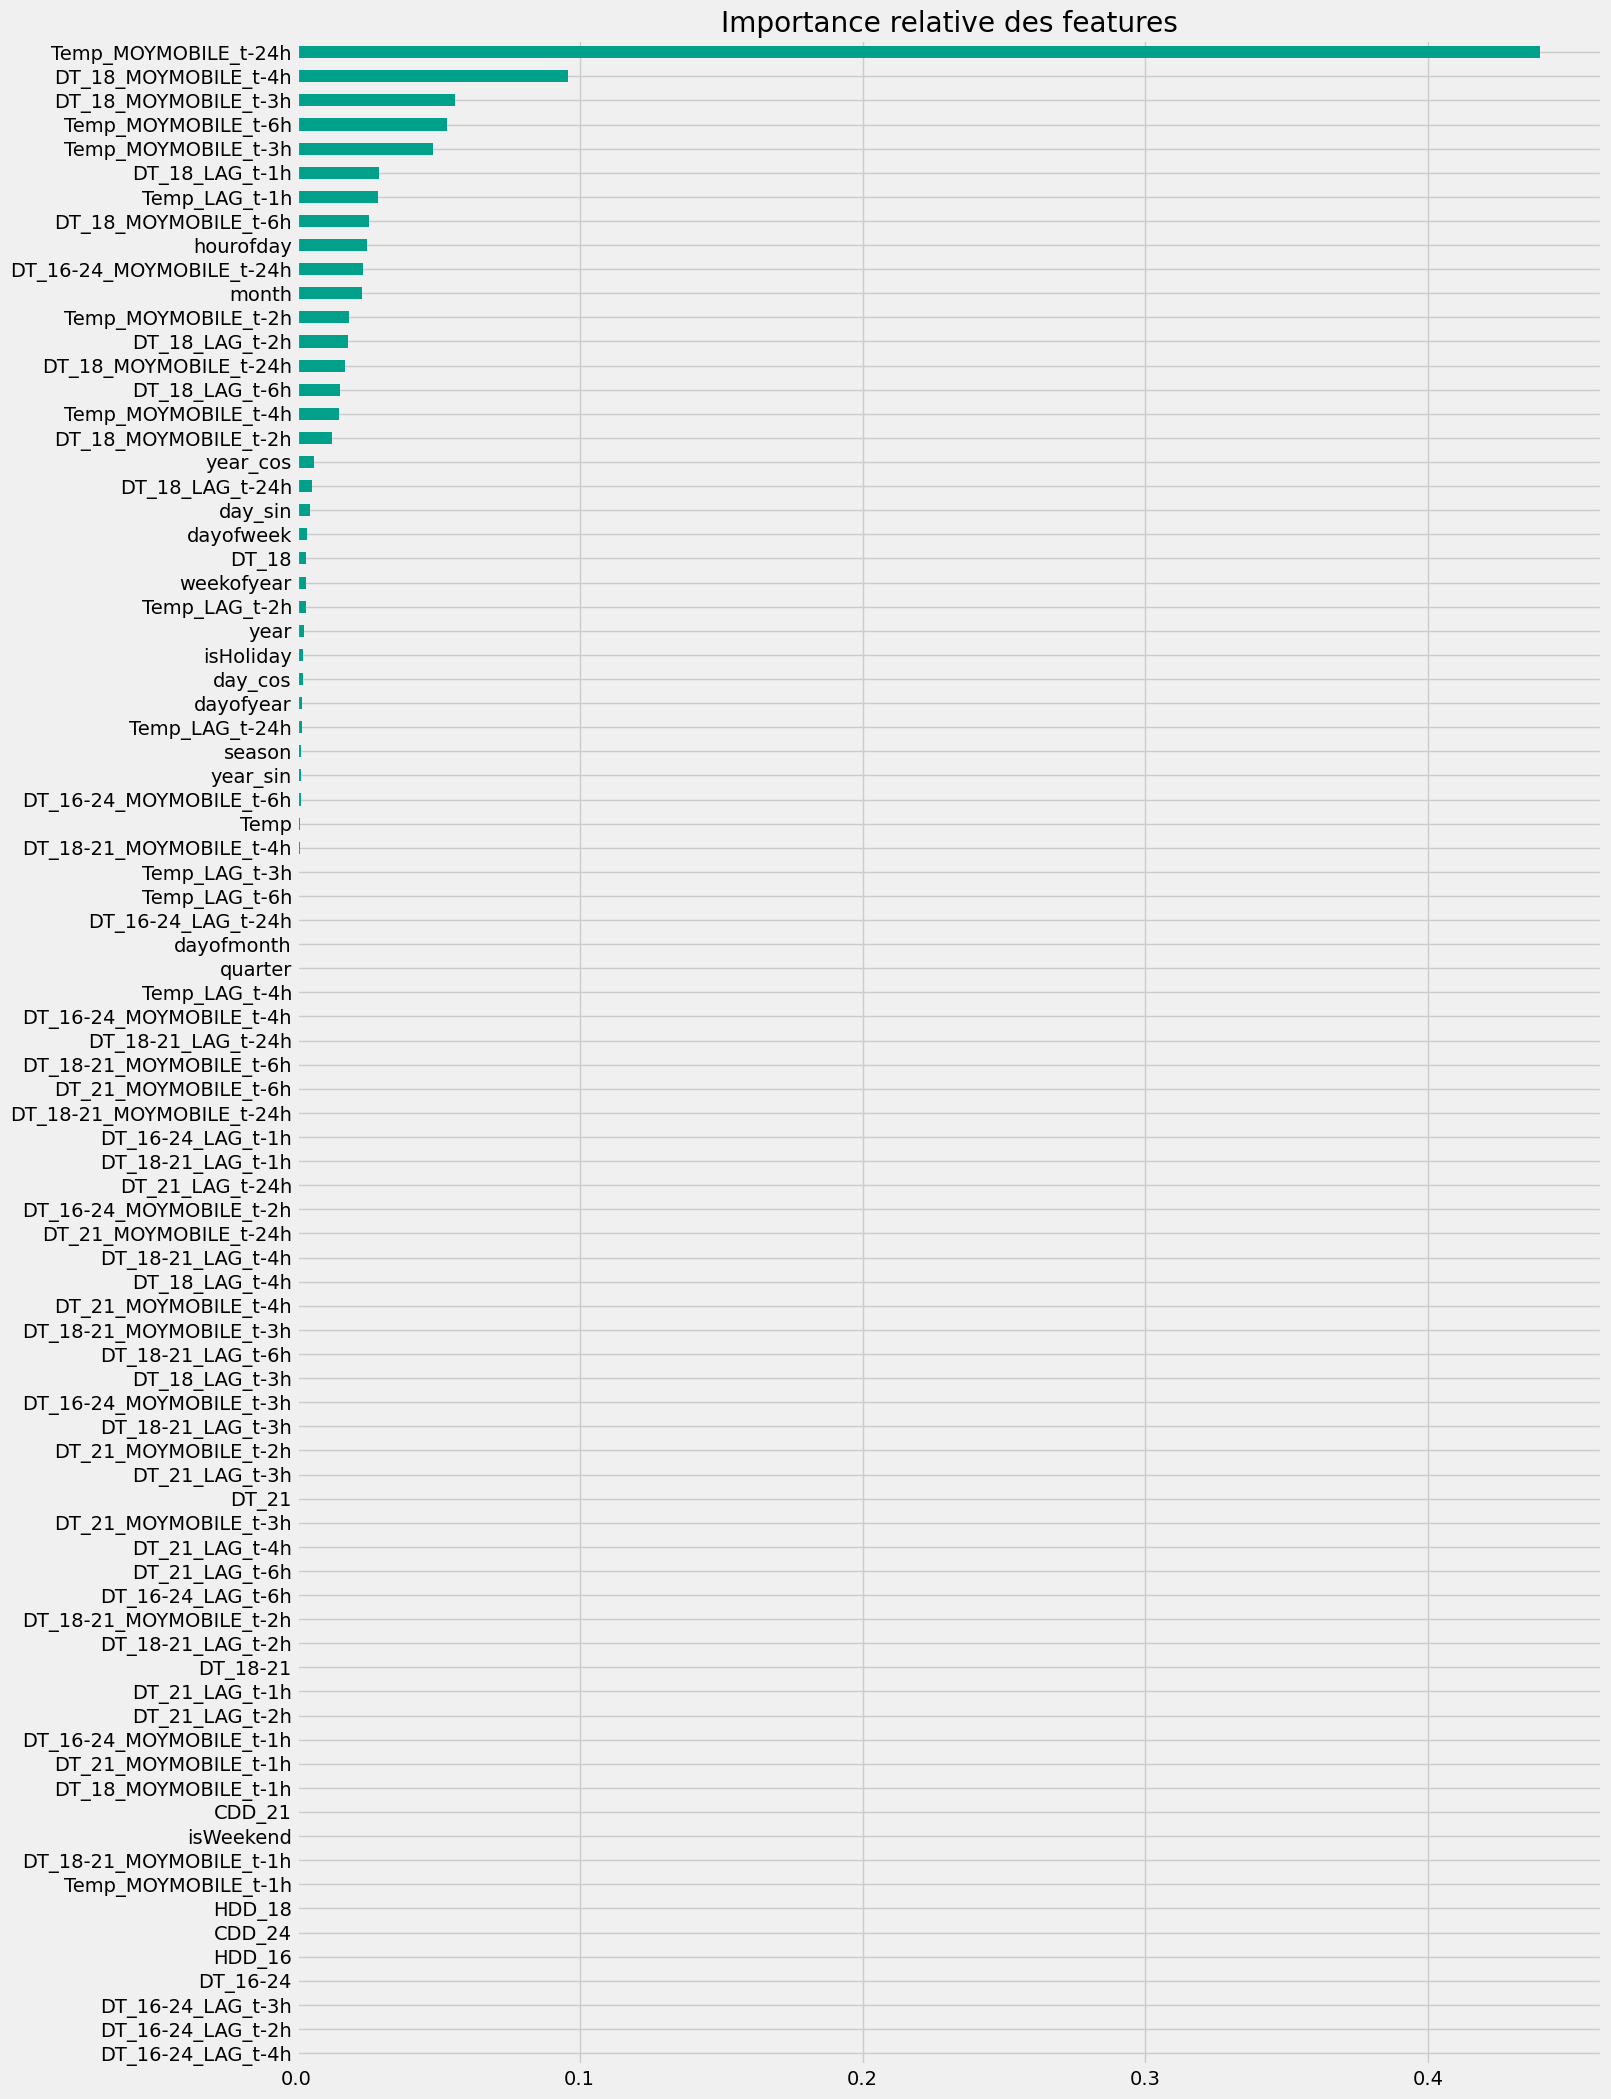

In [28]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values("Importance").plot(
    figsize=(15, 25),
    kind="barh",
    title="Importance relative des features",
    legend=False,
    color=colors_pal[1],
)
plt.show()

Nous pouvons bien voir que les moyennes mobiles sont très importantes dans les prédictions, étant 7 fois présents sur les 10 premiers, les lags étant présents 2 fois et l'heure du jour 1 fois seulement. 

Gardons seulement les 20 premiers features pour une 3e passe préliminaire et pour voir l'impact sur le résultat. 

In [29]:
FEATURES_TOP20 = (
    fi.sort_values("Importance", ascending=False)
    .head(20)
    .index.to_list()
)
X_train = train[FEATURES_TOP20]
y_train = train[TARGET]

X_test = test[FEATURES_TOP20]
y_test = test[TARGET]

In [ ]:
n_estim = 2000  # nb trees

reg = xgb.XGBRegressor(
    n_estimators=n_estim,
    early_stopping_rounds=50,
    learning_rate=0.01,
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False,
)

In [ ]:
rmse_top_20 = reg.best_score
print(
    f"Le meilleur RMSE sur les données d'entraînement est : {rmse_top_20:0.2f} par rapport à {rmse_tous_features:0.2f} avec le calcul de tous les features, soit {(rmse_tous_features-rmse_top_20)/rmse_tous_features:0.0%} mieux."
)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)
fi.sort_values("Importance").plot(
    figsize=(15, 5),
    kind="barh",
    title="Importance relative des features",
    legend=False,
    color=colors_pal[1],
)
plt.show()

L'ordre des features en importance a changé quand on utilise les top 20 précédent.  L'erreur a aussi augmenté. 

Une chose est certaine, il faut probablement évaluer l'intérêt d'ajouter des features de moyenne mobile avec plus d'heures de décallage. 

# Deuxième partie - renforcir le modèle


## Inspiration

- Vidéo Partie 2 : https://youtu.be/z3ZnOW-S550?si=VcoYQ4S5Zlcqffyr
- Kaggle notebook : https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

## Validation croisée (*Time Series Cross Validation*)

Nous désirons tester plusieurs durées différentes d'entraînement afin de maximiser nos données.

Dans une première vague (*fold*), 1 an d'entraînement, 1 an de test.

Dans la 2e, 2 ans d'entraînement, 1 an de test. Etc. 

test_size = 1 an

In [ ]:
df = import_and_create_features_no_categorical(
    fin="20221231"
).dropna()

In [ ]:
n_split = 3

tss = TimeSeriesSplit(
    n_splits=n_split, test_size=24 * 365 * 1, gap=24
)
df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(
    n_split, 1, figsize=(15, 8), sharex=True
)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train["MW"].plot(
        ax=axs[fold],
        label="Données Entraînement",
        title=f"Test/Training split - Vague {fold}",
        ylabel="MW",
    )
    test["MW"].plot(
        ax=axs[fold],
        label="Données Test",
    )
    axs[fold].axvline(
        test.index.min(),
        color="black",
        ls="--",
        linewidth=2,
    )

    fold += 1
plt.tight_layout()
plt.show()

Comme nous n'avons pas énormément des données (seulement 4 ans), nous nous questionnons à savoir si ce sera suffisant.  À suivre.

## Délai et moyenne mobile sur la cible

- Quelle était la cible (demande) dans le passé.

_**Cela implique que nous avons les données de la demande en MW en continu (donc impossible de faire des prévisions actuellement, car 2023 n'est pas complète pour l'instant)**_


Réutilisons les mêmes fonctions que plus tôt, mais avevc la caractéristique 'MW'.


> Dans la démo, il fait un lag de 364 jours (1 an), alors que nous utilisons des lags très court sur la Temp.  
> Est-ce possible de faire un lag / moyenne mobile de quelques heures, étant donnné que cela ne fonctionnera pas sur les prévisions (la prévions MW à t + 100h ne connaît pas le MW à t+99h..)  
> **À valider**

In [ ]:
df = create_lag_features(
    df,
    caract=["MW"],
    lags=[364 * 24 * 1, 364 * 24 * 2, 364 * 24 * 3],
)  # 1,2,3 ans

## Entraînement avec la validation croisée (cross-validation)

In [ ]:
n_split = 3

tss = TimeSeriesSplit(
    n_splits=n_split, test_size=24 * 365 * 1, gap=24
)
df = df.sort_index()

FEATURES = df.columns.to_list()[1:]  # Enlevons MW
TARGET = "MW"


fold = 0
regressions = []
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        # base_score=0.5,
        # booster="gbtree",
        n_estimators=2000,  # 1000
        early_stopping_rounds=50,
        # objective="reg:linear",
        # max_depth=3,
        learning_rate=0.01,
    )
    reg.fit(
        X_train,
        y_train,
        eval_set=[
            (X_train, y_train),
            (X_test, y_test),
        ],
        verbose=100,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    regressions.append(reg)

In [ ]:
print(f"Résultats moyen {np.mean(scores):0.4f}")
print(f"Résultat de chaque vague :{scores}")

i = 0
for r in regressions:
    i += r.best_iteration
    print("Meilleure itération : ", r.best_iteration)

print(
    "Meilleure itération moyenne", i / len(regressions)
)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)
fi.sort_values("Importance", ascending=True).tail(
    5
).plot(kind="barh")

In [ ]:
fi.loc[fi.index == "MW_LAG_t-8736h"]

Le lag d'un an sur la demande semble très peu significatif dans les résultats. Nous pouvons éviter cette caractéristique, qui pourrait nous empêcher de faire des prévisions à plus long terme. 

---  

## Prédictions dans le futur

Afin de profiter de l'ensemble des données que nous avons, nous entraînons le modèle sur les 4 années disponibles avec les mêmes paramètres que précedemment.

### Entraînement sur l'ensemble des données disponibles

In [31]:
(
    df,
    InfoDates,
) = import_and_create_features_no_categorical(
    lags=[
        1,
        2,
        3,
        4,
        6,
        24,
        364 * 24 * 1,
        364 * 24 * 2,
        364 * 24 * 3,
    ],
    fenetres=[1, 2, 3, 4, 6, 8, 12, 16, 24],
    fin="20221231",
    getInfoDate=True,
)

df = df.dropna()

print(InfoDates)

{
    'dateMin': Timestamp('2018-01-01 00:00:00'),
    'dateMax': Timestamp('2023-12-18 23:00:00'),
    'dateMaxMW': Timestamp('2023-12-03 00:00:00')
}

In [32]:
FEATURES = df.columns.to_list()[
    1:
]  # Enlevons  en première colonne
TARGET = "MW"

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    # base_score=0.5,
    # booster='gbtree',
    n_estimators=2000,
    # objective='reg:linear',
    # max_depth=3,
    learning_rate=0.01,
)
reg.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=250,
)

[0]	validation_0-rmse:22760.55215
[250]	validation_0-rmse:2007.77815
[500]	validation_0-rmse:489.70071
[750]	validation_0-rmse:365.05354
[1000]	validation_0-rmse:319.39422
[1250]	validation_0-rmse:284.42936
[1500]	validation_0-rmse:258.81346
[1750]	validation_0-rmse:237.36482
[1999]	validation_0-rmse:219.27955


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### DF avec toutes les dates disponibles pour prédictions

On va chercher toutes les dates futures, ou dans notre cas, à partir du **12 novembre 2023**, où nous commençons à avoir de l'historique de la demande en MW + période d'environ 16 jours dans le futur où nous n'en avons pas. 

In [33]:
# DF avec données historiques + 16 jours de prédictions de températures
df_all_time = (
    import_and_create_features_no_categorical(
        lags=[
            1,
            2,
            3,
            4,
            6,
            24,
            364 * 24 * 1,
            364 * 24 * 2,
            364 * 24 * 3,
        ],
        fenetres=[1, 2, 3, 4, 6, 8, 12, 16, 24],
    )
)

df_all_time["d"] = df_all_time.index
df_all_time["isFuture"] = df_all_time["d"].apply(
    lambda x: x > InfoDates.get("dateMaxMW")
)

## Pour avoir de la demande à comparer avec prédictions
df_all_time["isFuture_but_MW_History"] = df_all_time[
    "d"
].apply(lambda x: x > datetime(2023, 11, 12))

df_all_time = df_all_time.drop(columns=["d"])

df_all_time = df_all_time.loc[
    df_all_time.Temp.notna()
]  # Enlève données Temp manquantes à la fin du df

df_all_time.tail(5)

,MW,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,month,dayofweek,season,isWeekend,isHoliday,day_sin,day_cos,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21,Temp_LAG_t-1h,DT_18-21_LAG_t-1h,DT_16-24_LAG_t-1h,DT_18_LAG_t-1h,DT_21_LAG_t-1h,Temp_LAG_t-2h,DT_18-21_LAG_t-2h,DT_16-24_LAG_t-2h,DT_18_LAG_t-2h,DT_21_LAG_t-2h,Temp_LAG_t-3h,DT_18-21_LAG_t-3h,DT_16-24_LAG_t-3h,DT_18_LAG_t-3h,DT_21_LAG_t-3h,Temp_LAG_t-4h,DT_18-21_LAG_t-4h,DT_16-24_LAG_t-4h,DT_18_LAG_t-4h,DT_21_LAG_t-4h,Temp_LAG_t-6h,DT_18-21_LAG_t-6h,DT_16-24_LAG_t-6h,DT_18_LAG_t-6h,DT_21_LAG_t-6h,Temp_LAG_t-24h,DT_18-21_LAG_t-24h,DT_16-24_LAG_t-24h,DT_18_LAG_t-24h,DT_21_LAG_t-24h,Temp_LAG_t-8736h,DT_18-21_LAG_t-8736h,DT_16-24_LAG_t-8736h,DT_18_LAG_t-8736h,DT_21_LAG_t-8736h,Temp_LAG_t-17472h,DT_18-21_LAG_t-17472h,DT_16-24_LAG_t-17472h,DT_18_LAG_t-17472h,DT_21_LAG_t-17472h,Temp_LAG_t-26208h,DT_18-21_LAG_t-26208h,DT_16-24_LAG_t-26208h,DT_18_LAG_t-26208h,DT_21_LAG_t-26208h,Temp_MOYMOBILE_t-1h,DT_18-21_MOYMOBILE_t-1h,DT_16-24_MOYMOBILE_t-1h,DT_18_MOYMOBILE_t-1h,DT_21_MOYMOBILE_t-1h,Temp_MOYMOBILE_t-2h,DT_18-21_MOYMOBILE_t-2h,DT_16-24_MOYMOBILE_t-2h,DT_18_MOYMOBILE_t-2h,DT_21_MOYMOBILE_t-2h,Temp_MOYMOBILE_t-3h,DT_18-21_MOYMOBILE_t-3h,DT_16-24_MOYMOBILE_t-3h,DT_18_MOYMOBILE_t-3h,DT_21_MOYMOBILE_t-3h,Temp_MOYMOBILE_t-4h,DT_18-21_MOYMOBILE_t-4h,DT_16-24_MOYMOBILE_t-4h,DT_18_MOYMOBILE_t-4h,DT_21_MOYMOBILE_t-4h,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-8h,DT_18-21_MOYMOBILE_t-8h,DT_16-24_MOYMOBILE_t-8h,DT_18_MOYMOBILE_t-8h,DT_21_MOYMOBILE_t-8h,Temp_MOYMOBILE_t-12h,DT_18-21_MOYMOBILE_t-12h,DT_16-24_MOYMOBILE_t-12h,DT_18_MOYMOBILE_t-12h,DT_21_MOYMOBILE_t-12h,Temp_MOYMOBILE_t-16h,DT_18-21_MOYMOBILE_t-16h,DT_16-24_MOYMOBILE_t-16h,DT_18_MOYMOBILE_t-16h,DT_21_MOYMOBILE_t-16h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h,isFuture,isFuture_but_MW_History
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-18 15:00:00,NaN,-0.6,15,4,2023,352,18,51,12,0,3,0,0,-0.707107,-7.071068e-01,-0.229653,0.973273,0.0,18.6,0.0,16.6,18.6,16.6,18.6,21.6,-0.9,18.9,16.9,18.9,21.9,-1.0,19.0,17.0,19.0,22.0,-0.7,18.7,16.7,18.7,21.7,-0.1,18.1,16.1,18.1,21.1,0.3,17.7,15.7,17.7,20.7,0.9,17.1,15.1,17.1,20.1,-1.3,19.3,17.3,19.3,22.3,-5.3,23.3,21.3,23.3,26.3,-1.1,19.1,17.1,19.1,22.1,-0.6,18.6,16.6,18.6,21.6,-0.75,18.75,16.75,18.75,21.75,-0.833333,18.833333,16.833333,18.833333,21.833333,-0.800,18.800,16.800,18.800,21.800,-0.516667,18.516667,16.516667,18.516667,21.516667,-0.3375,18.3375,16.3375,18.3375,21.3375,-0.258333,18.258333,16.258333,18.258333,21.258333,-0.21875,18.21875,16.21875,18.21875,21.21875,0.033333,17.966667,15.966667,17.966667,20.966667,True,True
2023-12-18 16:00:00,NaN,-0.4,16,4,2023,352,18,51,12,0,3,0,0,-0.866025,-5.000000e-01,-0.228956,0.973437,0.0,18.4,0.0,16.4,18.4,16.4,18.4,21.4,-0.6,18.6,16.6,18.6,21.6,-0.9,18.9,16.9,18.9,21.9,-1.0,19.0,17.0,19.0,22.0,-0.7,18.7,16.7,18.7,21.7,0.2,17.8,15.8,17.8,20.8,0.8,17.2,15.2,17.2,20.2,-2.4,20.4,18.4,20.4,23.4,-5.0,23.0,21.0,23.0,26.0,-1.9,19.9,17.9,19.9,22.9,-0.4,18.4,16.4,18.4,21.4,-0.50,18.50,16.50,18.50,21.50,-0.633333,18.633333,16.633333,18.633333,21.633333,-0.725,18.725,16.725,18.725,21.725,-0.616667,18.616667,16.616667,18.616667,21.616667,-0.4000,18.4000,16.4000,18.4000,21.4000,-0.275000,18.275000,16.275000,18.275000,21.275000,-0.24375,18.24375,16.24375,18.24375,21.24375,-0.016667,18.016667,16.016667,18.016667,21.016667,True,True
2023-12-18 17:00:00,NaN,-0.4,17,4,2023,352,18,51,12,0,3,0,0,-0.965926,-2.588190e-01,-0.228258,0.973601,0.0,18.4,0.0,16.4,18.4,16.4,18.4,21.4,-0.4,18.4,16.4,18.4,21.4,-0.6,18.6,16.6,18.6,21.6,-0.9,18.9,16.9,18.9,21.9,-1.0,19.0,17.0,19.0,22.0,-0.1,18.1,16.1,18.1,21.1,0.8,17.2,15.2,17.2,20.2,-2.9,20.9,18.9,20.9,23.9,-4.1,22.1,20.1,22.1,25.1,-1.5,19.5,17.5,19.5,22.5

In [34]:
# Gardons les dates futures (ou dans ce cas, les dates d'historique de demande - 12 nov 2023)
future_w_features = df_all_time.query(
    "isFuture_but_MW_History"
).copy()

# Réalisons les prédictions sur les données "futures"
future_w_features["pred"] = reg.predict(
    future_w_features[FEATURES]
)

future_w_features[
    [
        "MW",
        "isFuture",
        "isFuture_but_MW_History",
        "pred",
    ]
]

,MW,isFuture,isFuture_but_MW_History,pred
date,,,,
2023-11-12 01:00:00,21648.75,False,True,22667.156250
2023-11-12 02:00:00,21683.00,False,True,22636.228516
2023-11-12 03:00:00,21834.50,False,True,22570.437500
2023-11-12 04:00:00,22058.50,False,True,22577.271484
2023-11-12 05:00:00,22467.50,False,True,22547.648438
...,...,...,...,...
2023-12-18 15:00:00,NaN,True,True,25936.445312
2023-12-18 16:00:00,NaN,True,True,26382.355469
2023-12-18 17:00:00,NaN,True,True,27397.310547


### Visualisation des résultats

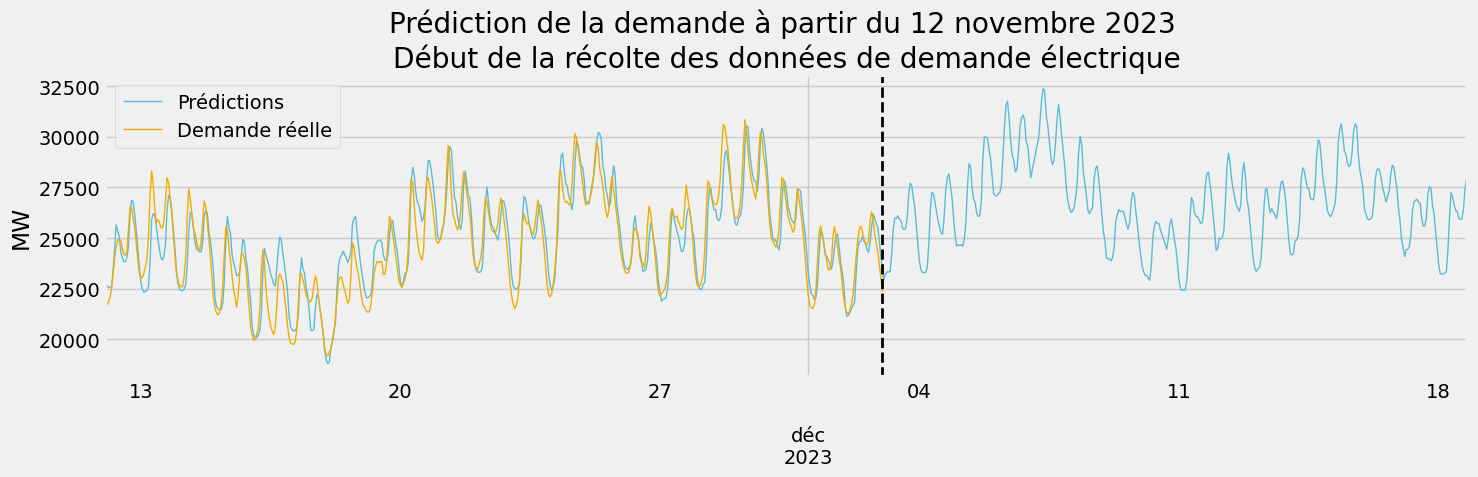

In [35]:
ax = future_w_features["pred"].plot(
    figsize=(15, 5),
    color=colors_pal[4],
    ms=1,
    lw=1,
    title="Prédiction de la demande à partir du 12 novembre 2023 \nDébut de la récolte des données de demande électrique",
    label="Prédictions",
    xlabel="",
    ylabel="MW",
)

future_w_features["MW"].plot(
    ax=ax,
    color=colors_pal[2],
    ms=1,
    lw=1,
    label="Demande réelle",
    xlabel="",
)

ax.axvline(
    datetime(2023, 12, 3),
    color="black",
    ls="--",
    linewidth=2,
)

ax.legend()
plt.tight_layout()
plt.show()

Les prédictions sont débutées à partir du 12 nov.

Nous avons un historique à partir du 12 jusqu'au 3 décembre, que nous pouvons comparer avec les données réelles enregistrées. 

Au-delà du 3 décembre, nous avons seulement des prévisions en fonction des prévisions météo. 

Effectuons une visualisation sur quelques jours seulement pour apprécier le résultat.

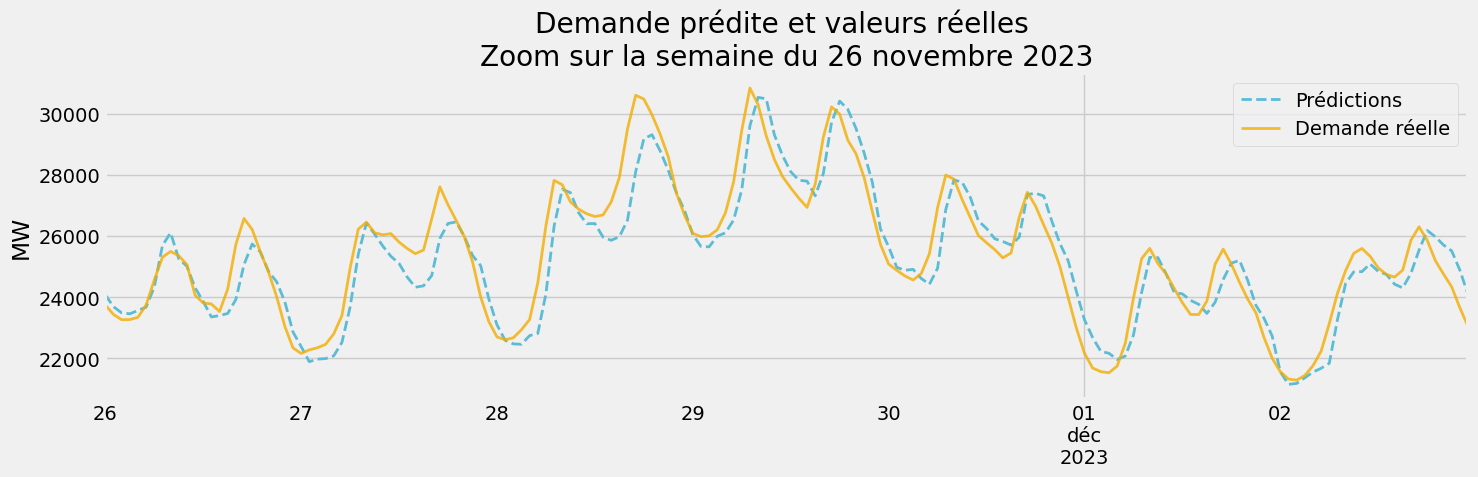

In [36]:
future_w_features_zoom = future_w_features[
    "20231126":"20231202"
].copy()

ax = future_w_features_zoom["pred"].plot(
    figsize=(15, 5),
    color=colors_pal[4],
    ms=1,
    lw=2,
    ls="--",
    title="Demande prédite et valeurs réelles \nZoom sur la semaine du 26 novembre 2023",
    label="Prédictions",
    xlabel="",
    ylabel="MW",
)

future_w_features_zoom["MW"].plot(
    ax=ax,
    color=colors_pal[2],
    ms=1,
    lw=2,
    alpha=0.8,
    label="Demande réelle",
    xlabel="",
)

ax.axvline(
    datetime(2023, 12, 3),
    color="black",
    ls="--",
    linewidth=2,
)

ax.legend()
plt.tight_layout()
plt.show()

Nous voyons que les valeurs prédites et réelles sont très près une de l'autre. 

## Calcul des erreurs


In [37]:
_ = calcul_erreurs(
    future_w_features,
    nomColPrediction="pred",
    nomColReel="MW",
)

Le MSE est de 940062.2, le RMSE est de 969.6 et le MAE de 757.5 pour un calcul sur 504 valeurs.

Nous pouvons voir que les prévisions sont très bonnes en comparaison avec la demande réelle enregistrée. Pour une simple régression, le RMSE était à près de 2400. C'est aussi très visible sur le graphique que la prédiction suit très bien la valeur réelle de la demande.


# Apprentissages

Nous avons de bons résultats préliminaires avec ce modèle, pour être en mesure de faire des prévisions à court terme. 

Les délais (*lags*) sur la demande en MW en tant que tel n'est pas significative en termes d’importance dans le modèle. Nous décidons de ne pas l'utiliser dans le futur, car elle pourrait potentiellement nous empêcher de faire des prévisions à plus long terme.  

Si nous décidons de poursuivre avec XGBoost, nous pourrons réaliser les tâches suivantes. 

## À faire 

- [ ] Cross-validation : à explorer un peu plus si requis
- [ ] Test plusieurs features
- [ ] Création de nouveaux features en fonction de ceux qui seront les meilleurs
- [ ] Tests paramètres XGBoost   
      - https://365datascience.com/tutorials/python-tutorials/xgboost-lgbm/#:~:text=Step%208%3A%20Tune%20the%20XGBoost%20Model   
      - https://optuna.org/  :  Optimisation automatisée des paramètres 